In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

# Transformaciones
from sklearn.preprocessing import StandardScaler
from scipy.signal import detrend

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Obtención de la serie CMAPSS Dataset

In [110]:
pd.set_option("display.max_columns", None)

ruta_dataset = 'data/raw_data/train_FD001.txt'

headers = [
    "unit_number",
    "time_cycles",
    "operational_setting_1",
    "operational_setting_2",
    "operational_setting_3"]

headers += [f"sensor_{i}" for i in range(1, 22)]

In [111]:
df_FD001 = pd.read_csv(ruta_dataset, delim_whitespace=True, header=None, names=headers)
df_FD001.head()

/tmp/ipykernel_28735/1599241784.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_FD001 = pd.read_csv(ruta_dataset, delim_whitespace=True, header=None, names=headers)


,unit_number,time_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [112]:
df = df_FD001.copy()
sensores = [f'sensor_{i}' for i in range(1,10)]
df = df[sensores]
df['conteo'] = range(1, len(df) + 1)
df = df[['conteo'] + sensores]

# Eliminar las columnas con valores constantes en sensores
constantes = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_7']
df = df.drop(columns=constantes)

df.head()

,conteo,sensor_2,sensor_3,sensor_4,sensor_8,sensor_9
0,1,641.82,1589.70,1400.60,2388.06,9046.19
1,2,642.15,1591.82,1403.14,2388.04,9044.07
2,3,642.35,1587.99,1404.20,2388.08,9052.94
3,4,642.35,1582.79,1401.87,2388.11,9049.48
4,5,642.37,1582.85,1406.22,2388.06,9055.15


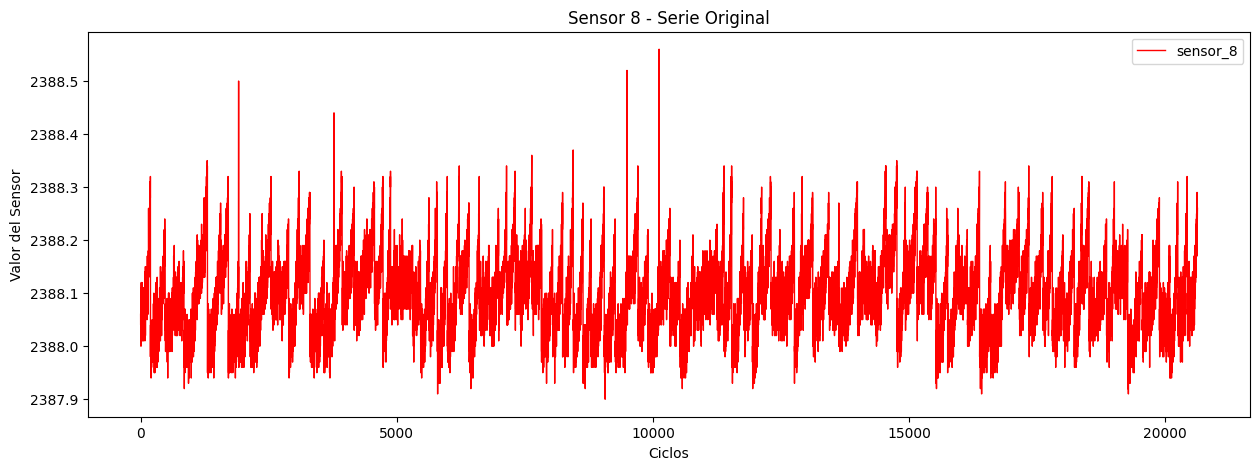

In [113]:
n_sensor = 8
df[f'sensor_{n_sensor}'].plot(title=f'Sensor {n_sensor} - Serie Original',
                    figsize=(15, 5),
                    color='red', 
                    linewidth=1, 
                    legend=True)
plt.xlabel('Ciclos'),
plt.ylabel('Valor del Sensor')
plt.show()

### Serie seleccionada para trabajar - 8

In [114]:
serie = df[[f'sensor_{n_sensor}']]
print('----- Dimensiones de la serie seleccionada -----')
print(serie.shape)
print('\n----- Estadísticas descriptivas de la serie seleccionada -----')
print(serie.describe())
print('\n----- Información de la serie seleccionada -----')
print(serie.info())
print('\n----- Valores nulos en la serie seleccionada -----')
print(serie.isnull().sum())


----- Dimensiones de la serie seleccionada -----
(20631, 1)

----- Estadísticas descriptivas de la serie seleccionada -----
           sensor_8
count  20631.000000
mean    2388.096652
std        0.070985
min     2387.900000
25%     2388.050000
50%     2388.090000
75%     2388.140000
max     2388.560000

----- Información de la serie seleccionada -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_8  20631 non-null  float64
dtypes: float64(1)
memory usage: 161.3 KB
None

----- Valores nulos en la serie seleccionada -----
sensor_8    0
dtype: int64


### Splits y Transformación para el conjunto Train

In [ ]:
def transformar_serie(data, train_frac=0.70, val_frac=0.15):
    """
    Aplica:
    1) Detrend lineal a TODA la serie para evitar discontinuidades.
    2) Normalización Z-score ajustada SOLO con training (evita data leakage).
    """

    data = np.asarray(data).flatten()
    n = len(data)

    # --- Splits ---
    train_end = int(n * train_frac)
    val_end   = int(n * (train_frac + val_frac))

    # 1) Detrend a toda la serie completa
    data_dt = detrend(data)

    # 2) Separar
    train_dt = data_dt[:train_end]
    val_dt   = data_dt[train_end:val_end]
    test_dt  = data_dt[val_end:]

    # 3) Normalización SOLO con train
    scaler = StandardScaler().fit(train_dt.reshape(-1,1))

    train_norm = scaler.transform(train_dt.reshape(-1,1)).flatten()
    val_norm   = scaler.transform(val_dt.reshape(-1,1)).flatten()
    test_norm  = scaler.transform(test_dt.reshape(-1,1)).flatten()

    print("Train:", len(train_norm))
    print("Val:  ", len(val_norm))
    print("Test: ", len(test_norm))

    return {
        "train": train_dt,
        "val": val_dt,
        "test": test_dt,
        "train_norm": train_norm,
        "val_norm": val_norm,
        "test_norm": test_norm,
        "scaler": scaler,
        "indices": {
            "train_end": train_end,
            "val_end": val_end}}

resultados = transformar_serie(serie)

train_norm = resultados['train_norm']
val_norm   = resultados['val_norm']     
test_norm = resultados['test_norm']
scaler_y = resultados['scaler']
idx_test_start = resultados['indices']['val_end']

Train: 14441
Val:   3095
Test:  3095


### Creación de las ventanas

In [116]:
def create_windows(serie, input_len=50, pred_len=1):
    X, y = [], []
    for i in range(len(serie) - input_len - pred_len):
        X.append(serie[i:i+input_len])
        y.append(serie[i+input_len:i+input_len+pred_len])
    return np.array(X), np.array(y)

input_len = 50
pred_len = 1

X_train, y_train = create_windows(train_norm, input_len, pred_len)
X_val, y_val     = create_windows(val_norm, input_len, pred_len)
X_test, y_test   = create_windows(test_norm, input_len, pred_len)

X_train = X_train.reshape(-1, 50)  # (batch, seq)
X_val   = X_val.reshape(-1, 50)
X_test  = X_test.reshape(-1, 50)

# Ahora sí → meter el canal
X_train = X_train[:, None, :]  # (batch, 1, 50)
X_val   = X_val[:, None, :]
X_test  = X_test[:, None, :]


### Convertir a Pytorch

In [117]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

### Data Loaders

In [118]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

### Modelo CNN1D

In [119]:
class ResidualBlock1D(nn.Module):
    def __init__(self, channels, kernel_size=5, dropout=0.2):
        super().__init__()

        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.bn1   = nn.BatchNorm1d(channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.bn2   = nn.BatchNorm1d(channels)
        self.relu2 = nn.ReLU()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = out + x  # residual connection
        out = self.relu2(out)
        return out


class CNN1D(nn.Module):
    def __init__(self, input_channels=1, base_channels=64, input_len=50):
        super().__init__()

        # Capa inicial
        self.conv_in = nn.Conv1d(input_channels, base_channels, kernel_size=5, padding=2)
        self.bn_in   = nn.BatchNorm1d(base_channels)
        self.relu    = nn.ReLU()

        # 3 bloques residuales 
        self.block1 = ResidualBlock1D(base_channels, kernel_size=5)
        self.block2 = ResidualBlock1D(base_channels, kernel_size=5)
        self.block3 = ResidualBlock1D(base_channels, kernel_size=5)
        self.block4 = ResidualBlock1D(base_channels, kernel_size=5)
        self.block5 = ResidualBlock1D(base_channels, kernel_size=5)

        # Pooling para comprimir
        self.pool = nn.AdaptiveAvgPool1d(10)  # reduce siempre a 10

        # Capa final
        self.fc = nn.Linear(base_channels * 10, 1)

    def forward(self, x):
        x = self.relu(self.bn_in(self.conv_in(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.pool(x)   # (batch, channels, 10)
        x = x.reshape(x.size(0), -1)
        out = self.fc(x)
        return out


model = CNN1D()
print(f"Modelo simple. Parámetros: {sum(p.numel() for p in model.parameters()):,}")

Modelo simple. Parámetros: 207,873


### Entrenar

Epoch 1 - Train Loss: 0.6198 - Val Loss: 0.8268 - LR: 0.001000
Epoch 2 - Train Loss: 0.3404 - Val Loss: 0.6678 - LR: 0.001000
Epoch 3 - Train Loss: 0.3169 - Val Loss: 0.6598 - LR: 0.001000
Epoch 4 - Train Loss: 0.3055 - Val Loss: 0.8920 - LR: 0.001000
Epoch 5 - Train Loss: 0.2758 - Val Loss: 0.6956 - LR: 0.001000
Epoch 6 - Train Loss: 0.2766 - Val Loss: 0.7312 - LR: 0.001000
Epoch 7 - Train Loss: 0.2610 - Val Loss: 0.7515 - LR: 0.000500
Epoch 8 - Train Loss: 0.2465 - Val Loss: 0.5267 - LR: 0.000500
Epoch 9 - Train Loss: 0.2368 - Val Loss: 0.6298 - LR: 0.000500
Epoch 10 - Train Loss: 0.2303 - Val Loss: 0.6665 - LR: 0.000500
Epoch 11 - Train Loss: 0.2244 - Val Loss: 0.8073 - LR: 0.000500
Epoch 12 - Train Loss: 0.2165 - Val Loss: 0.9670 - LR: 0.000250
Epoch 13 - Train Loss: 0.2063 - Val Loss: 0.9005 - LR: 0.000250
Epoch 14 - Train Loss: 0.1998 - Val Loss: 1.3154 - LR: 0.000250
Epoch 15 - Train Loss: 0.1962 - Val Loss: 1.1319 - LR: 0.000250
Epoch 16 - Train Loss: 0.1918 - Val Loss: 1.5388 

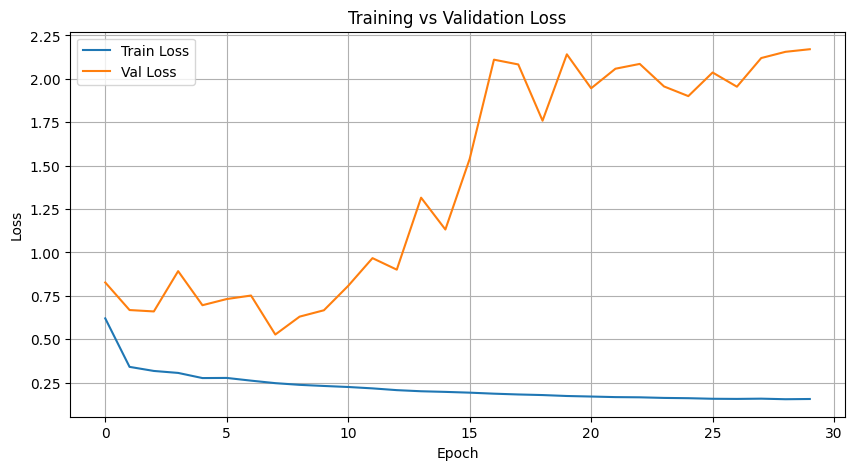

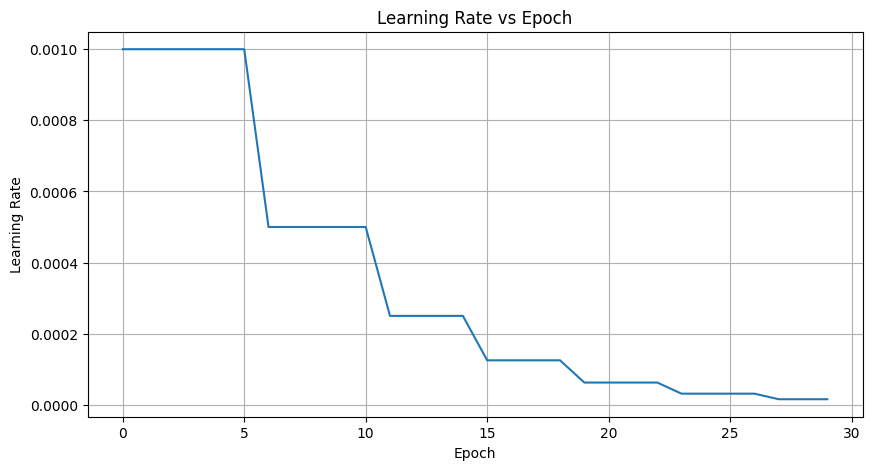

In [120]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

n_epocas = 30

train_losses = []
val_losses = []
lrs = []

for epoch in range(n_epocas):
    # Train
    model.train()
    epoch_loss = 0.0

    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    # Guardar LR actual
    lrs.append(optimizer.param_groups[0]['lr'])

    print(
        f"Epoch {epoch+1} - "
        f"Train Loss: {epoch_loss:.4f} - "
        f"Val Loss: {val_loss:.4f} - "
        f"LR: {optimizer.param_groups[0]['lr']:.6f}")


# GRAFICAR LOSS
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

# GRAFICAR LEARNING RATE
plt.figure(figsize=(10,5))
plt.plot(lrs)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Epoch")
plt.grid(True)
plt.show()



### Función para recuperar la escala original

In [123]:
def inverse_transform_target(y, scaler):

    # Convertir a CPU numpy si viene de PyTorch
    if isinstance(y, torch.Tensor):
        y = y.detach().cpu().numpy()

    # Asegurar forma correcta: (N, 1)
    if y.ndim == 1:
        y = y.reshape(-1, 1)

    # Aplicar inverse transform
    y_inv = scaler.inverse_transform(y)

    # Regresar como vector 1D
    return y_inv.flatten()

### Evaluación del modelo

In [136]:
def evaluate_model(model, test_loader, scaler_y, device="cpu"):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            pred = model(xb)

            preds.append(pred.cpu().numpy())
            trues.append(yb.cpu().numpy())

    # Concatenar todas las predicciones
    preds = np.concatenate(preds, axis=0).reshape(-1, 1)
    trues = np.concatenate(trues, axis=0).reshape(-1, 1)

    #  Recuperar escala original
    preds_original = inverse_transform_target(preds, scaler_y)
    trues_original = inverse_transform_target(trues, scaler_y)

    #  Calcular métricas
    rmse = np.sqrt(mean_squared_error(trues_original, preds_original))
    mae = mean_absolute_error(trues_original, preds_original)
    r2 = r2_score(trues_original, preds_original)

    return {
        "y_true": trues_original,
        "y_pred": preds_original,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }

result = evaluate_model(model, test_loader, scaler_y)

y_test_real = result["y_true"]
y_test_pred  = result["y_pred"]
rmse = np.round(result["rmse"], 4)
mae = np.round(result["mae"], 4)
r2 = np.round(result["r2"], 4)

n_test = len(y_test_real)
test_indices = np.arange(idx_test_start, idx_test_start + n_test)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


RMSE: 0.0791
MAE: 0.0506
R²: -0.4122


### Visualización

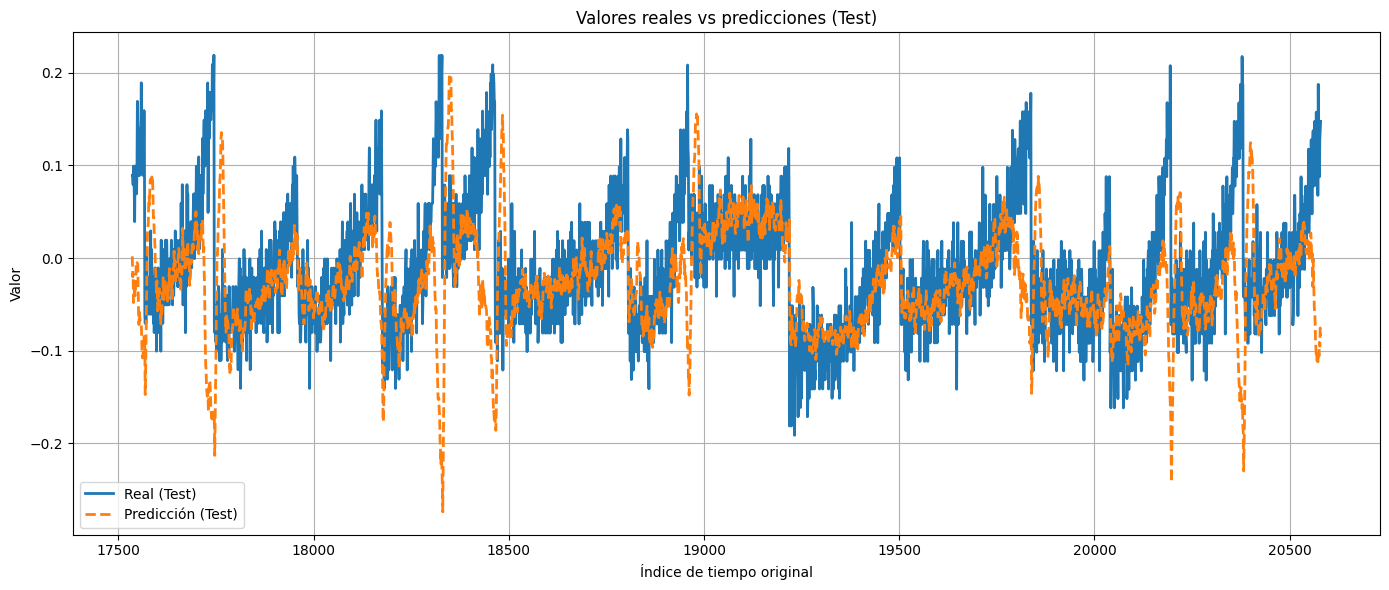

In [137]:
def plot_test_predictions_with_index(indices, y_test_real, y_test_pred, title="Valores reales vs predicciones (Test)"):
    plt.figure(figsize=(14, 6))
    plt.plot(indices, y_test_real, label="Real (Test)", linewidth=2)
    plt.plot(indices, y_test_pred, label="Predicción (Test)", linestyle="--", linewidth=2)
    plt.title(title)
    plt.xlabel("Índice de tiempo original")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_test_predictions_with_index(test_indices, y_test_real, y_test_pred)


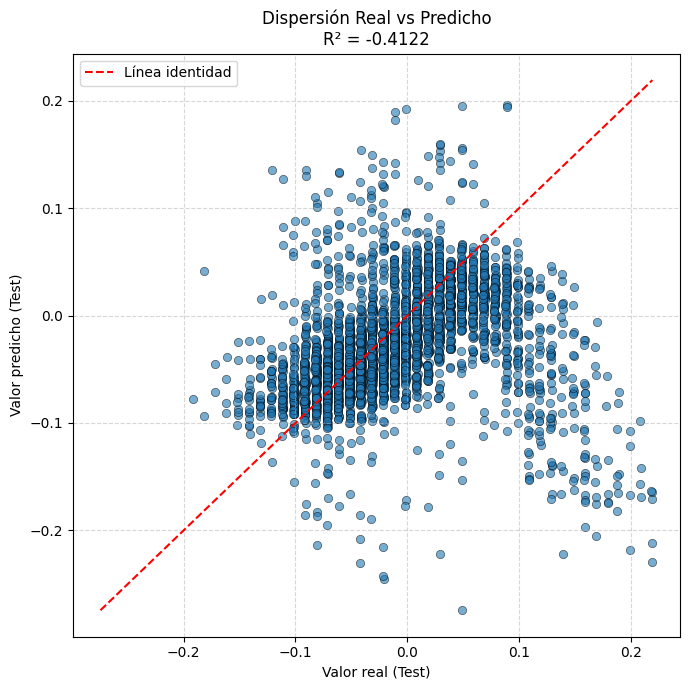

In [138]:
def plot_r2_scatter(y_true, y_pred, title="Dispersión Real vs Predicho"):
    # Asegurar forma correcta
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()

    # Calcular R²
    r2 = r2_score(y_true, y_pred)

    plt.figure(figsize=(7, 7))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolor="k", linewidth=0.5)
    
    # Línea identidad (y = x)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Línea identidad")

    plt.title(f"{title}\nR² = {r2:.4f}")
    plt.xlabel("Valor real (Test)")
    plt.ylabel("Valor predicho (Test)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_r2_scatter(y_test_real, y_test_pred)